In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import meta
import datetime
import yfinance as yf

# Notebook Model
This notebook analyzes a random forest whose parameters were optimized for the SNP 500 index. The bot traded for 15 years on all companies that had at least 30 years of data

In [85]:
value = pd.read_csv(meta.backtest_loc + 'RF-opt.csv').dropna()
snp_tick = yf.Ticker('^GSPC')
snp = snp_tick.history(start=value['date'].min(), end=value['date'].max(), interval='1d')
snp = snp.reset_index()[['Date', 'Close']]
snp['Date'] = snp['Date'].astype(str)
comb = pd.merge(snp, value, left_on='Date', right_on='date').drop(columns=['date'], axis=1)
comb['Close'] = comb['Close'] / comb.iloc[0, comb.columns.get_loc('Close')] * 100
comb['value'] = comb['value'] / comb.iloc[0, comb.columns.get_loc('value')].min() * 100

## Compare performance by the datetime format indicator
- ### I.E: Monthly, yearly
The table below indicates performance in a given window. The first table breaks performance down by year. The values in the colored cells indicate the diffrence in percent change of the SNP 500 and the Trading Bot for the given window.

In [86]:

## Returns the value associated with the largest day in the dataframe divided by the value associated
## with the smallest day in the dataframe
def get_window_performance(df, date_col, val_col):
    start = df.loc[df[date_col] == df[date_col].min(), val_col].iloc[0]
    end = df.loc[df[date_col] == df[date_col].max(), val_col].iloc[0]
    return end / start

## Returns a dataframe grouped by the given formatter with a ratio for each group indicating the value
## on the last day for that group divided by the value for the first day of that group
def get_performance_breakdown(day_val_df, formatters=['%Y'], date_col='date', val_col = 'value'):
    day_val_df[date_col] = pd.to_datetime(day_val_df[date_col])
    group_by_cols = []
    for i, formatter in enumerate(formatters):
        day_val_df['Date' + str(i)] = day_val_df[date_col].dt.strftime(formatter)
        group_by_cols.append('Date' + str(i))
    grouped = day_val_df.groupby(group_by_cols).apply(lambda df: get_window_performance(df, date_col, val_col))
    grouped.name = val_col
    return grouped.to_frame()

## Pre-define color ranges for the differences between bot and snp for easy comparison
## Boundaries are defined for one year. Use a scaler for different granularity
def get_colors(col, use_cols=None, scaler = 1):
    ret = col.copy()
    ret[:] = ''
    if (use_cols is not None) and (col.name not in use_cols):
        return ret
    
    neg_bounds = [-0.01, -0.05, -0.1, -0.25, -0.5, -1]
    pos_bounds = [-1 * n for n in neg_bounds]
    opacities = [0.1, 0.2, 0.4, 0.6, 0.75, 1]
    
    for i in range(len(neg_bounds)):
        ret[col <= neg_bounds[i] * scaler] = 'background-color:rgba(255, 0, 0, ' + str(opacities[i]) + ');'
        ret[col >= pos_bounds[i] * scaler] = 'background-color:rgba(0, 255, 0, ' + str(opacities[i]) + ');'
    return ret

## Colors the cells according to the differences using min-max normalization
def style_cells(col, use_cols=None):
    col = col.copy()
    if (use_cols is not None) and (col.name not in use_cols):
        col[:] = ''
        return col
    p_col = col > 0
    n_col = col <= 0
    max_pos = col.max()
    min_pos = col[p_col].min()
    max_neg = col[n_col].max()
    min_neg = col.min()
    col[p_col] = (col[p_col] - min_pos) / (max_pos - min_pos)
    col[n_col] = (col[n_col] - max_neg) / (min_neg - max_neg)
    col[n_col] = col[n_col].apply(lambda x: 'background-color:rgba(255, 0, 0, ' + str(x) + ');')
    col[p_col] = col[p_col].apply(lambda x: 'background-color:rgba(0, 255, 0, ' + str(x) + ');')
    return col

snp_perf = get_performance_breakdown(snp, date_col='Date', val_col='Close').rename(columns={'Close': 'SNP'})
bot_perf = get_performance_breakdown(value).rename(columns={'value': 'BOT'})
together = snp_perf.join(bot_perf)
together['DIFF'] = together['BOT'] - together['SNP']
together.style.apply(get_colors, use_cols=['DIFF'], axis=0)

,SNP,BOT,DIFF
Date0,,,
2006,1.039581,1.039757,0.000176
2007,1.036538,0.948404,-0.088134
2008,0.624153,0.590525,-0.033629
2009,1.196716,1.617671,0.420955
2010,1.110019,1.297107,0.187088
2011,0.988780,0.824372,-0.164408
2012,1.116776,1.091995,-0.024781
2013,1.263905,1.595474,0.331569
2014,1.123866,1.075073,-0.048793


In [87]:
snp_perf = get_performance_breakdown(snp, formatters=['%Y', '%m'], date_col='Date', val_col='Close').rename(columns={'Close': 'SNP'})
bot_perf = get_performance_breakdown(value, formatters=['%Y', '%m']).rename(columns={'Close': 'SNP'})
joined = snp_perf.join(bot_perf)
diff = joined['value'] - joined['SNP']
diff = diff.unstack()
diff.style.apply(get_colors, scaler =1/6, axis=0)

Date1,01,02,03,04,05,06,07,08,09,10,11,12
Date0,,,,,,,,,,,,
2006,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.033298,-0.018454
2007,-0.019221,0.027886,-0.018565,-0.029156,-0.041609,0.009928,0.024770,0.023233,0.007421,-0.019806,-0.003243,-0.032824
2008,0.044400,-0.036167,-0.001805,-0.029202,-0.007286,-0.007195,0.091446,0.021761,-0.053639,0.008393,0.010993,-0.075142
2009,-0.008525,-0.118139,0.254153,-0.029682,0.018946,-0.002462,0.077562,0.108150,0.004990,-0.035473,-0.036585,-0.002188
2010,-0.050662,0.045785,-0.010130,0.003347,0.110854,0.064426,0.057818,-0.003525,-0.005055,0.021971,-0.046004,0.027967
2011,-0.033183,-0.007963,-0.037433,-0.003617,-0.002847,-0.041009,-0.013707,0.024409,0.000509,0.031622,-0.134115,-0.018504
2012,0.058536,0.017583,0.023155,0.062584,-0.002705,0.036515,-0.045090,-0.028268,-0.035469,-0.038592,-0.000921,0.006740
2013,0.024579,0.024379,0.028433,0.013803,0.009911,0.011559,0.013171,-0.006087,-0.004702,-0.003249,0.017864,-0.008846
2014,-0.049325,-0.029082,-0.023015,0.002258,-0.005354,-0.011559,0.004888,0.003393,-0.003782,-0.056201,0.018270,-0.002627


In [88]:
## Dropping duplicates keeps the first value so you can use it to find the first date of each year
years = pd.to_datetime(comb['Date'])
years = years.dt.strftime('%Y').drop_duplicates().to_frame()
years.index.name = 'Index'
years = years.reset_index()

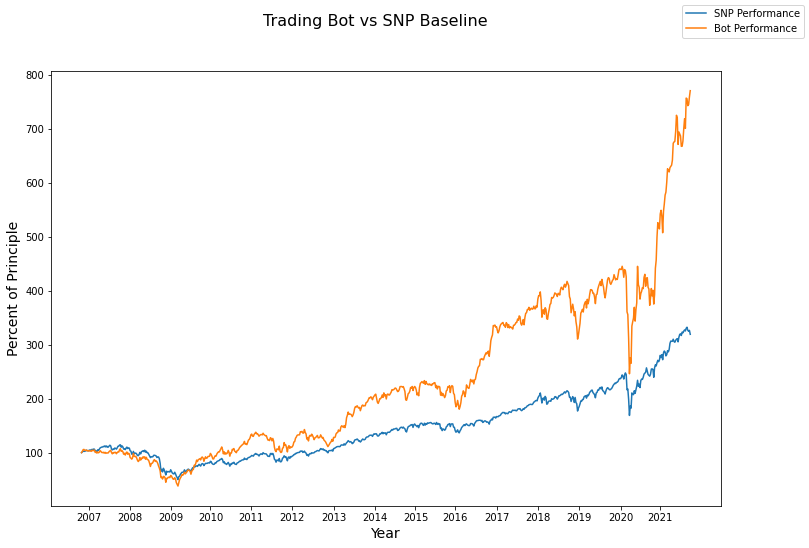

In [89]:
fig, ax = plt.subplots()
x = np.arange(len(comb))
ax.plot(x, comb['Close'], label='SNP Performance')
ax.plot(x, comb['value'], label='Bot Performance')
ax.set_xticks(years['Index'].values[1:])
ax.set_xticklabels(years['Date'].values[1:])
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Percent of Principle', fontsize=14)
fig.set_size_inches(12, 8)
fig.suptitle('Trading Bot vs SNP Baseline', fontsize=16)
fig.legend()
plt.savefig(meta.results_loc + str(datetime.datetime.now()) + '.png')